# Analisis Klaster Menggunakan Algoritma K-Means Berdasarkan Motto Negara : Pengelompokan Makna
Anggota Kelompok
- Teresia Yunita Putriani Nainggolan (6162001042)
- Ecclesiani (6162001215)

# Importing Libraries :

In [ ]:
!pip install geopandas

In [ ]:
!pip install Unidecode

In [ ]:
# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

# Corpus Loading

In [ ]:
data = pd.read_csv('Data Semboyan Negara.csv')
data.head()

,No,Country,Alpha-2,Alpha-3,Continent,Motto
0,1,Afghanistan,AF,AFG,Asia,There is no god but God; Muhammad is the messe...
1,2,Austria,AT,AUT,Europe,"The future is in our hands, Austria is in our ..."
2,3,Benin,BJ,BEN,Africa,"Fellowship, Justice, Labour"
3,4,Brunai Darussalam,BN,BRN,Asia,Always in service with God's guidance
4,5,Canada,CA,CAN,North America,From sea to sea


In [ ]:
corpus = data['Motto'].tolist()
corpus[18][0:447]

'Strength and consistency'

# Corpus Processing

In [ ]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

## The main corpus processing function.

In [ ]:
def processCorpus(corpus, language):
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    countries_list = [line.rstrip('\n') for line in open('countries.txt')] # Load .txt file line by line
    nationalities_list = [line.rstrip('\n') for line in open('nationalities.txt')] # Load .txt file line by line
    other_words = [line.rstrip('\n') for line in open('stopwords_scrapmaker.txt')] # Load .txt file line by line

    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase

        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, countries_list)
        listOfTokens = removeWords(listOfTokens, nationalities_list)
        listOfTokens = removeWords(listOfTokens, other_words)

        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
language = 'english'
corpus = processCorpus(corpus, language)
corpus[18][0:460]

'strength consist'

## Statistical Weighting of Words

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data=X.toarray(),columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

60 rows


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
god,0.785767,0.0,0.0,0.358966,0.0,0.0,0.0,0.0,0.0,0.0,...,0.565823,0.373494,0.513783,0.0,0.0,0.477803,0.0,0.363648,0.0,0.0
messeng,0.437361,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
muhammad,0.437361,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
achiev,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
almighti,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [ ]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
god,0.785767,0.0,0.0,0.358966,0.0,0.0,0.0,0.0,0.0,0.0,...,0.565823,0.373494,0.513783,0.0,0.0,0.477803,0.0,0.363648,0.0,0.0
messeng,0.437361,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
muhammad,0.437361,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
achiev,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
almighti,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


# K-Means

In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1)

        kmeans_results.update( {k : kmeans.fit(data)} )

    return kmeans_results

In [ ]:
# Running Kmeans from 1 to k
k = 9
kmeans_results = run_KMeans(k, final_df)

df = final_df.to_numpy()

In [ ]:
df

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.37408936, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.48838543, 0.        ,
        0.65579588]])

## Elbow Method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

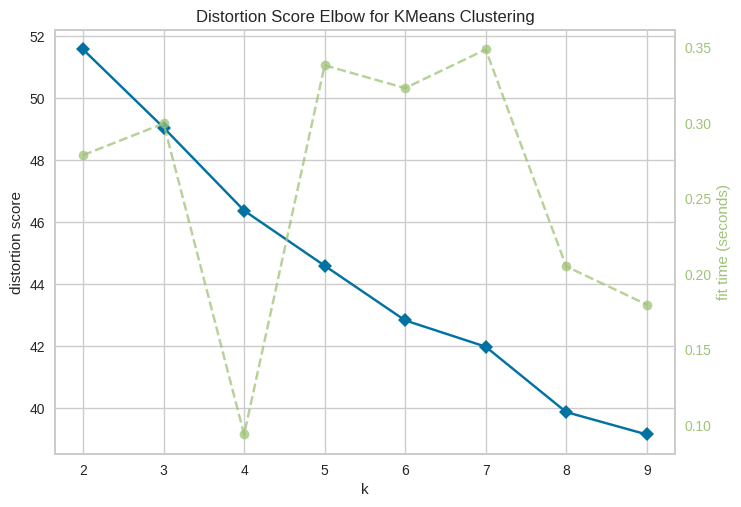

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
km = cluster.KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(df) #Fit the data to the visualizer
visualizer.show() #Finalize and render the figure

## Silhouette Score

In [ ]:
avg_dict = dict()
for n_clusters, kmeans in kmeans_results.items():
  kmeans_labels = kmeans.predict(df)
  silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
  avg_dict.update( {silhouette_avg : n_clusters} )

Avg = []
Ks = []
for avg in sorted(avg_dict.keys(), reverse=True):
  Avg.append(avg.round(4))
  Ks.append(avg_dict[avg])

silhouette_list = pd.DataFrame(
    {'K': Ks,
     'Averange': Avg
     })
silhouette_list = silhouette_list.sort_values(by=['K'])
silhouette_list

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  w

,K,Averange
7,2,0.0554
6,3,0.0610
3,4,0.0676
4,5,0.0632
2,6,0.0716
0,7,0.0951
1,8,0.0716
5,9,0.0629


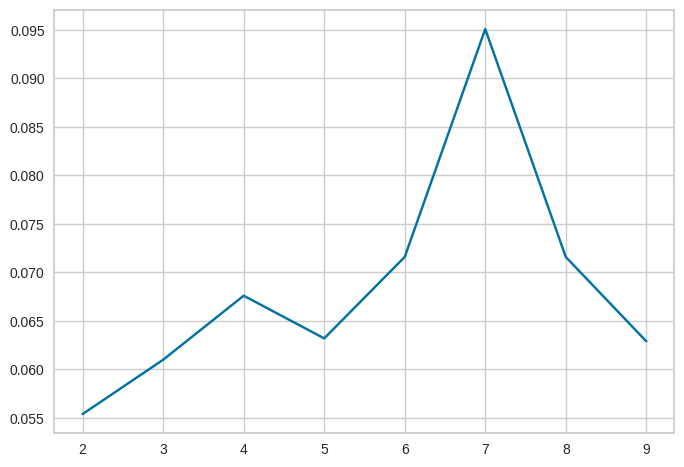

In [ ]:
#plot average
plt.plot(silhouette_list.K, silhouette_list.Averange)
plt.show()

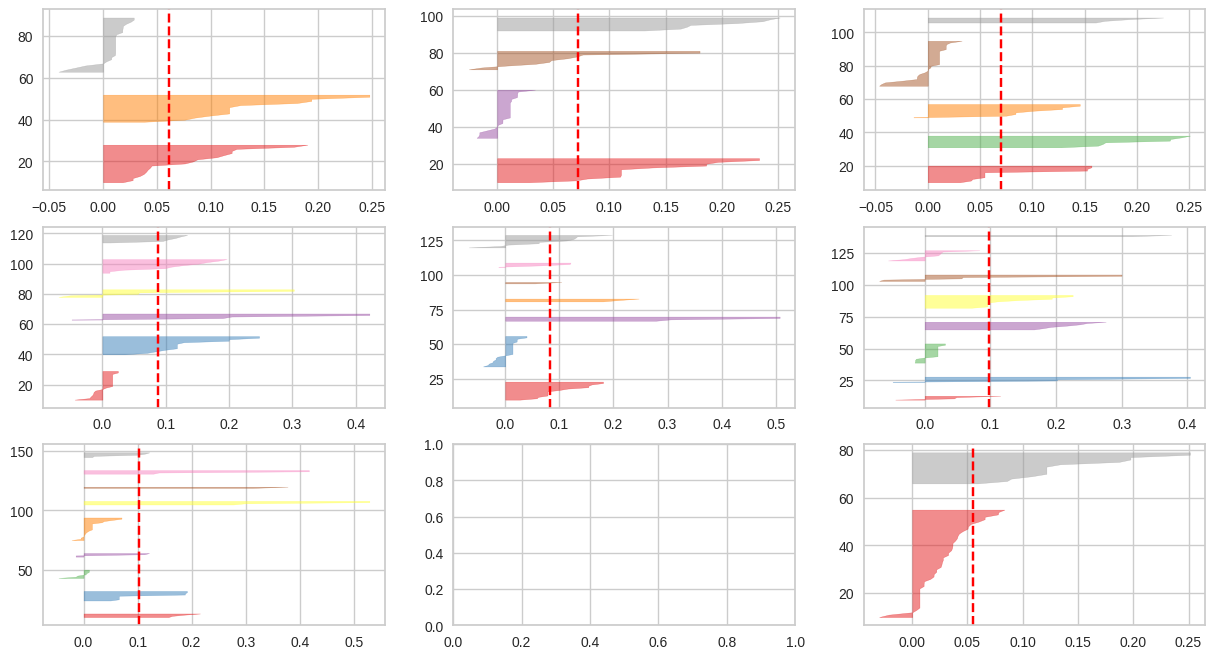

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 3, figsize=(15,8))
for i in [2,3,4,5,6,7,8,9]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = cluster.KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 3)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df)

# Cluster Analysis

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

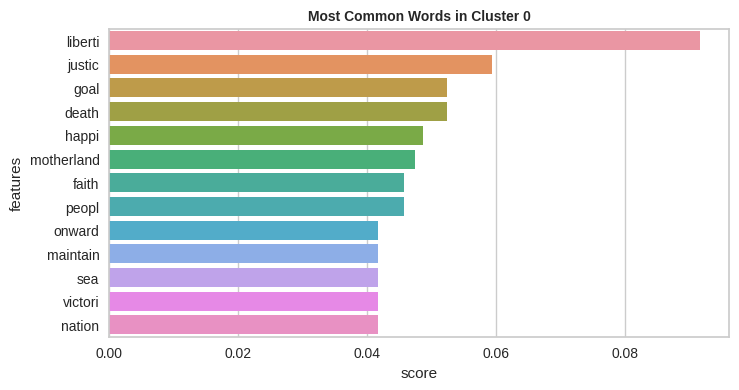

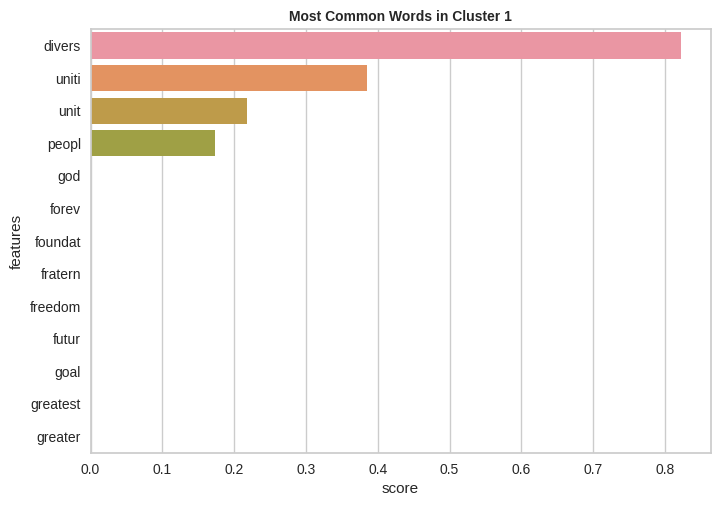

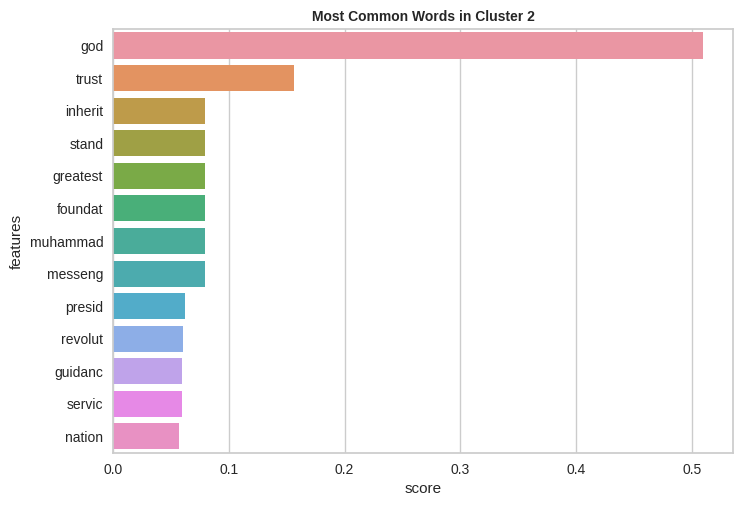

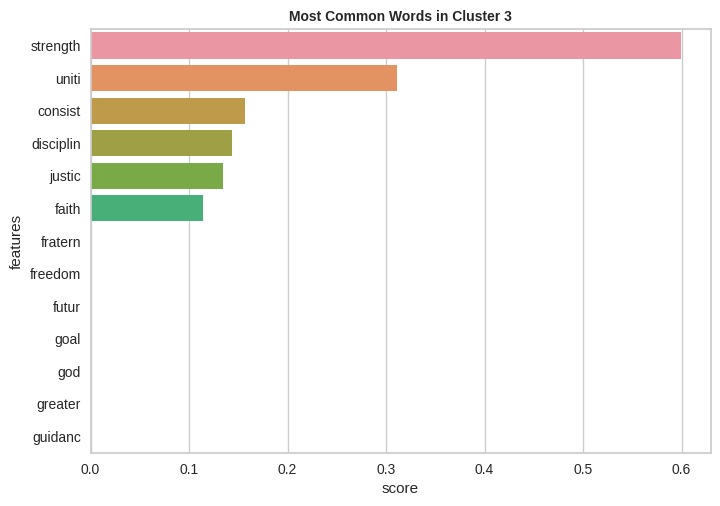

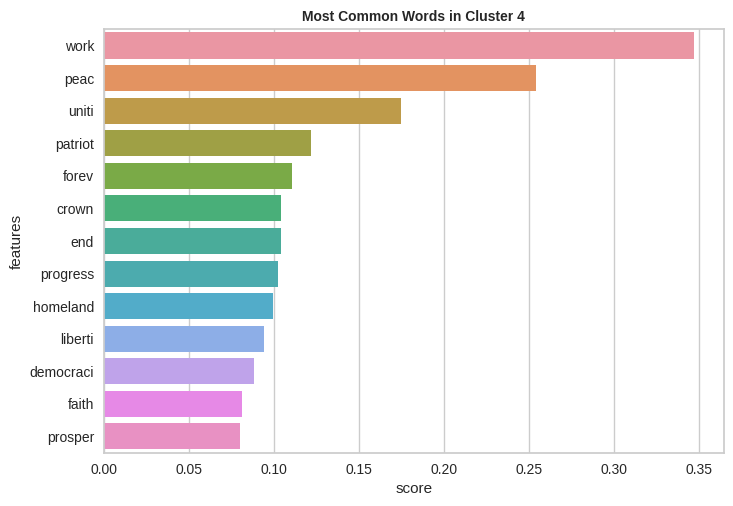

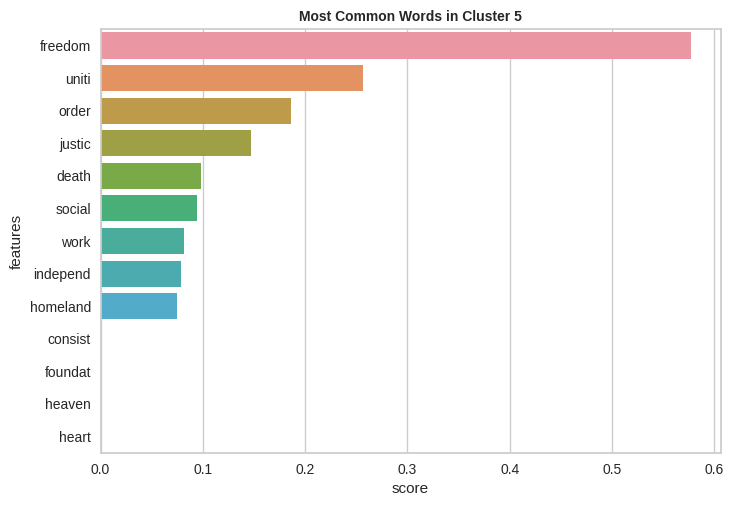

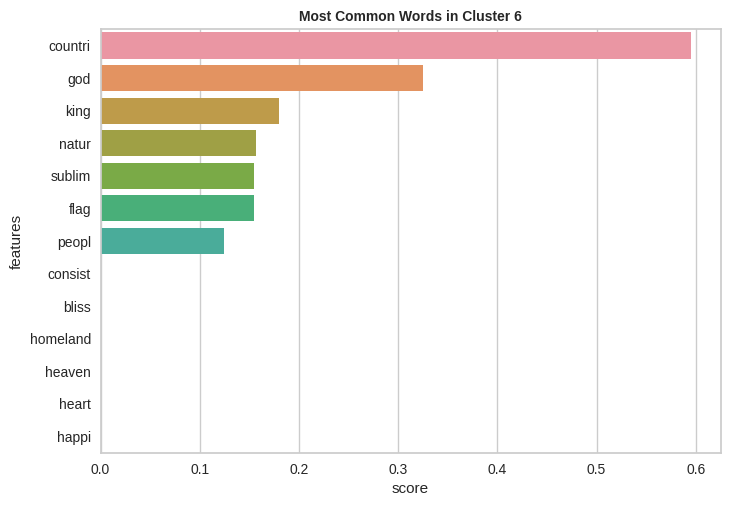

In [ ]:
best_result = 7
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

## Map of Words

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

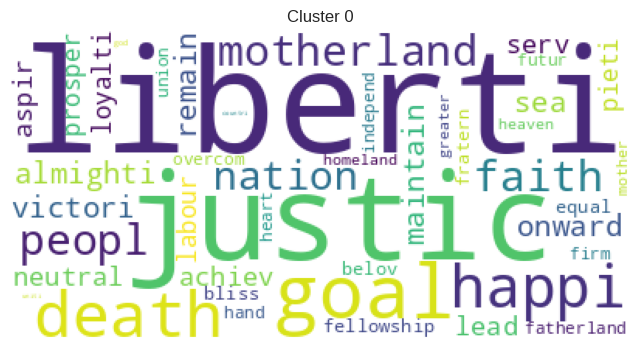

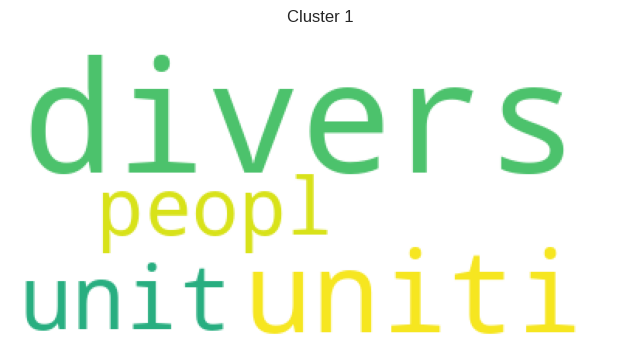

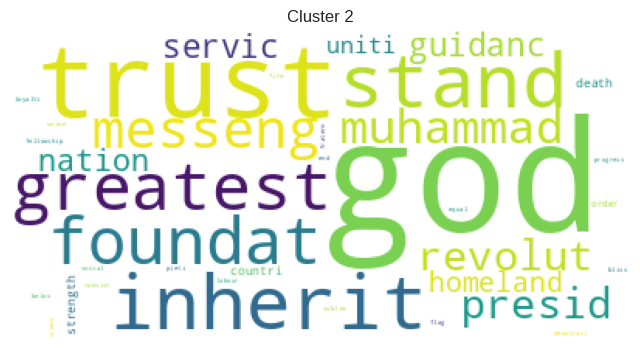

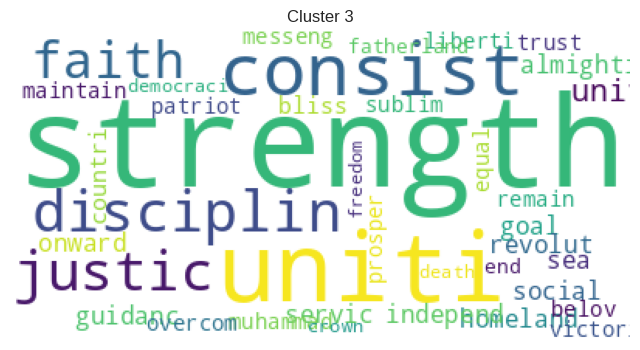

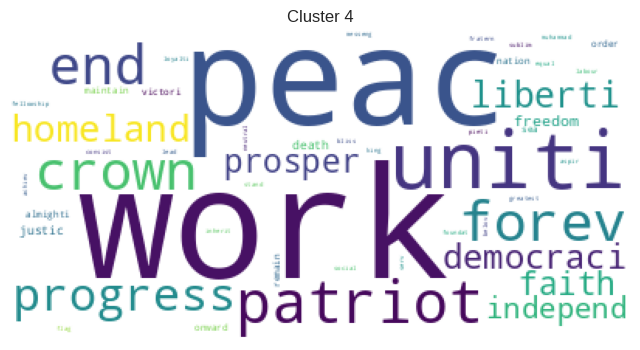

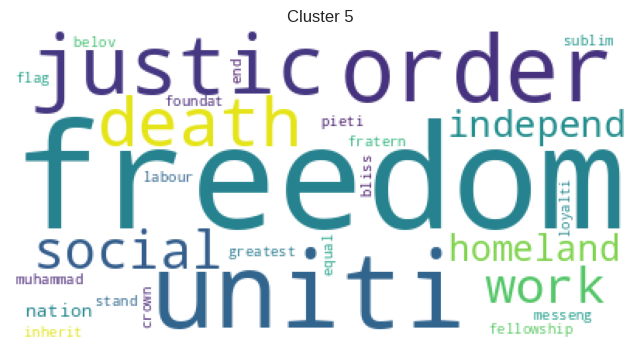

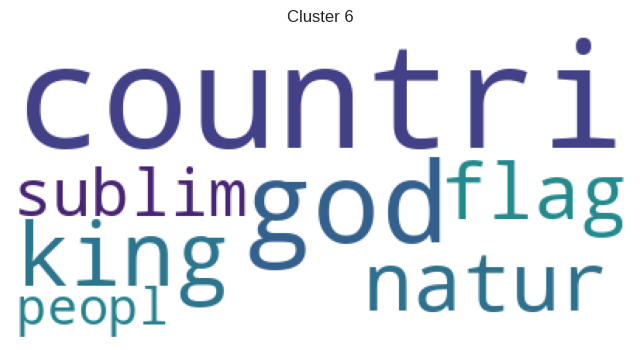

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

## Preparing our final groups for visualization

In [ ]:
# Assigning the cluster labels to each country
labels = kmeans.labels_
data['label'] = labels
data.head(61)

,No,Country,Alpha-2,Alpha-3,Continent,Motto,label
0,1,Afghanistan,AF,AFG,Asia,There is no god but God; Muhammad is the messe...,2
1,2,Austria,AT,AUT,Europe,"The future is in our hands, Austria is in our ...",0
2,3,Benin,BJ,BEN,Africa,"Fellowship, Justice, Labour",0
3,4,Brunai Darussalam,BN,BRN,Asia,Always in service with God's guidance,2
4,5,Canada,CA,CAN,North America,From sea to sea,0
5,6,Colombia,CO,COL,South America,Freedom and order,5
6,7,Costa Rica,CR,CRI,Central America,Work and Peace forever.,4
7,8,Cuba,CU,CUB,North America,"Fatherland or death, we shall overcome!",0
8,9,Frace,FR,FRA,Europe,"Liberty, equality, fraternity",0
9,10,Georgia,GE,GEO,Asia,Strength is in Unity!,3


## Visualization the Clustered Countries in a Map

In [ ]:
# Map Viz
import json
import geopandas as gpd

# Loading countries polygons
geo_path = 'world-countries.json'
country_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)

# Merging on the alpha-3 country codes
merge = pd.merge(gpf, data, left_on='id', right_on='Alpha-3')
data_to_plot = merge[["id", "name", "label", "geometry"]]

data_to_plot.head(3)

,id,name,label,geometry
0,AFG,Afghanistan,2,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,ARE,United Arab Emirates,2,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
2,AUT,Austria,0,"POLYGON ((16.97967 48.12350, 16.90375 47.71487..."


In [ ]:
import branca.colormap as cm

# Creating a discrete color map
values = data_to_plot[['label']].to_numpy()
color_step = cm.StepColormap(['r', 'y','g','b', 'm','c','w'], vmin=values.min(), vmax=values.max(), caption='step')

color_step

## Painting the Groups into a Choropleth Map

In [ ]:
import folium
from branca.element import Figure

def make_geojson_choropleth(display, data, colors):
    '''creates geojson choropleth map using a colormap, with tooltip for country names and groups'''
    group_dict = data.set_index('id')['label'] # Dictionary of Countries IDs and Clusters
    tooltip = folium.features.GeoJsonTooltip(["name", "label"], aliases=display, labels=True)
    return folium.GeoJson(data[["id", "name","label","geometry"]],
                          style_function = lambda feature: {
                               'fillColor': colors(group_dict[feature['properties']['id']]),
                               #'fillColor': test(feature),
                               'color':'black',
                               'weight':0.5
                               },
                          highlight_function = lambda x: {'weight':2, 'color':'black'},
                          smooth_factor=2.0,
                          tooltip = tooltip)

# Makes map appear inline on notebook
def display(m, width, height):
    """Takes a folium instance and embed HTML."""
    fig = Figure(width=width, height=height)
    fig.add_child(m)
    #return fig

In [ ]:
# Initializing our Folium Map
m = folium.Map(location=[43.5775, -10.106111], zoom_start=2.3, tiles='cartodbpositron')

# Making a choropleth map with geojson
geojson_choropleth = make_geojson_choropleth(["Country:", "Group:"], data_to_plot, color_step)
geojson_choropleth.add_to(m)

width, height = 1300, 675
display(m, width, height)
m